# LDA on nCovMemory articles

import libraries

In [21]:
#import
import os
import numpy as np
import pandas as pd
import re
import itertools
from collections import Counter
import pickle
import jieba
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

Filter warnings for a cleaner output

In [29]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# no warnings of type FutureWarning will be printed from now on


Reading the files as list of list, the smaller list containing a pair of text and filename.

In [22]:
#--reading the texts files
le_chemin = 'cleaned_articles'  # write the texts folder path

filenames = os.listdir(le_chemin)

lst = []

for filename in sorted(os.listdir(le_chemin)):  # for all file names in folder cleaned_articles
    #ignore hidden files
    if filename[0] != '.':

        file_path = os.path.join(le_chemin, filename)  # Create path with folder path and file names
        #x = file_path[17:-4]
        x = int(filename[:-4]) #we want the filename/id as int and not string
        boite = []
        with open(file_path, 'r') as f2:
            data = f2.read() #take the text in the file
       
        boite.append(x)
        boite.append(data)
        
        lst.append(boite)

Transform the list of list into a dataframe

In [23]:
df_texts = pd.DataFrame(lst) 


Let's check that everything is correct

In [24]:
df_texts.head()

,0,1
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,10,武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...
2,100,黄冈一个武汉周边城市的疫情防控样本\n黄冈一个武汉周边城市的疫情防控样本黄冈一个武汉周边城市...
3,1000,超长相处期被父母逼疯的年轻人\n超长相处期被父母逼疯的年轻人超长相处期被父母逼疯的年轻人超长...
4,1001,武汉后临时外卖员我多跑一单就减少一个家庭感染的可能\n武汉后临时外卖员我多跑一单就减少一个家...


Now let's rename the dataframe columns. (we do not want to set the id column as index because some files are missing)

In [25]:
df_texts = df_texts.rename(columns = {0:'id',1:'texts'})
df_texts.head()

,id,texts
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,10,武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...
2,100,黄冈一个武汉周边城市的疫情防控样本\n黄冈一个武汉周边城市的疫情防控样本黄冈一个武汉周边城市...
3,1000,超长相处期被父母逼疯的年轻人\n超长相处期被父母逼疯的年轻人超长相处期被父母逼疯的年轻人超长...
4,1001,武汉后临时外卖员我多跑一单就减少一个家庭感染的可能\n武汉后临时外卖员我多跑一单就减少一个家...


let's reorder the dataframe based on the id column

In [26]:
df_texts = df_texts.sort_values(by = 'id' )
df_texts.head()

,id,texts
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1108,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2206,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3304,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
3860,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...


Reset the index after re-ordering

In [27]:
df_texts = df_texts.reset_index(drop=True)
df_texts.head()

,id,texts
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...


We have a perfect dataframe. It is easy to display and the texts are easy to access individually or in group. We can save it just in case.

In [8]:
#df_texts.to_csv (r'df_texts_without_index.csv', index = False, header=True) #save it without index if we want to open it with R
#df_texts.to_csv (r'df_texts_with_index.csv', index = True, header=True) #with index

The texts are already quite clean. We need to cut them with jieba. We start by loading our words with priority cutting into jieba before cutting. We do that because we want to remove the media names which comes back many times in the articles but do not provide more information on a topic. To be able to remove them from a stopword list, they must be cut properly first, hence the priority cutting.

In [28]:
with open('UsrWords.txt', 'r', encoding='utf8') as f:
    custom_noun = f.readlines()
    for noun in custom_noun:
        jieba.add_word(noun.replace('\n', ''), freq=None, tag='n')

cutting

In [30]:
df_texts['words'] = df_texts.texts.apply(jieba.lcut)
df_texts.head()

,id,texts,words
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,"[个, 临时, 发, 往, 武汉, 的, 口罩, \n, 个, 临时, 发, 往, 武汉, ..."
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,"[武汉, 隔离, 疫区, 信息, 孤岛, 与, 一辆, 鄂车, 的, 漂流, \n, 武汉,..."
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,"[我家, 离, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学..."
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,"[疫情, 危机, 中, 不, 被, 看见, 的, 人们, 武汉, 周边城市, 百姓, 的, ..."
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,"[孝感, 前线, 医生, 武汉, 更难, 我们, 下面, 不好意思, 提, 要求, \n, ..."


Stopwords removal

In [31]:
fh = open("stopwords.txt")
stopwords=[]
stopwords.append('\n') #append the '\n' in the beginning otherwise it would be erased by strip
stopwords.append('%')  #we append some special characters, I am also goign to add it to the cleaning function pre-processing
stopwords.append('|')  #the texts but sometimes it does not catch them all
stopwords.append('△')
stopwords.append('▼')
stopwords.append('｜')
stopwords.append('\u3000') #this is a special empty space, I also removed tab space in the cleaning function, perhaps that'll help too
for line in fh:
    line = line.rstrip()
    stopwords.append(line)

def stp_removal(wordlist, stopwords=stopwords):
    lili=[]
    for word in wordlist:
        if word not in stopwords:
            lili.append(word)
    return lili


In [32]:
df_texts['cleaned_words'] = df_texts.words.apply(stp_removal)
df_texts.head()

,id,texts,words,cleaned_words
0,1,个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,"[个, 临时, 发, 往, 武汉, 的, 口罩, \n, 个, 临时, 发, 往, 武汉, ...","[临时, 发, 武汉, 口罩, 临时, 发, 武汉, 口罩, 临时, 发, 武汉, 口罩, ..."
1,2,武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,"[武汉, 隔离, 疫区, 信息, 孤岛, 与, 一辆, 鄂车, 的, 漂流, \n, 武汉,...","[武汉, 隔离, 疫区, 信息, 孤岛, 一辆, 鄂车, 漂流, 武汉, 隔离, 疫区, 信..."
2,3,我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,"[我家, 离, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学...","[我家, 华南, 海鲜, 市场, 很近, 返乡, 封城, 过年, 一位, 武汉, 大学生, ..."
3,4,疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,"[疫情, 危机, 中, 不, 被, 看见, 的, 人们, 武汉, 周边城市, 百姓, 的, ...","[疫情, 危机, 看见, 武汉, 周边城市, 百姓, 自救, 行动, 疫情, 危机, 看见,..."
4,5,孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,"[孝感, 前线, 医生, 武汉, 更难, 我们, 下面, 不好意思, 提, 要求, \n, ...","[孝感, 前线, 医生, 武汉, 更难, 下面, 不好意思, 提, 要求, 孝感, 前线, ..."


check if necessary

In [33]:
#x = df_texts.cleaned_words[df_texts.id == 3862]
#print(x)
#print(list(x))

Prepare to LDA 

In [34]:
data_lemmatized = df_texts.cleaned_words
#print(data_lemmatized)

id2word = gensim.corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_above= 0.29) 

corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]

Even though we already checked the number of subjects in the other lda, let's see if anything changed

In [52]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'/home/bilatli/DEV/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'/home/bilatli/DEV/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
   coherence_values = []
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.wrappers.LdaMallet(
         mallet_path, corpus=corpus, num_topics=num_topics, iterations=1000, workers = 6, id2word=id2word
      )
      model_list.append(model)
      
      coherencemodel = CoherenceModel(
      model=model, texts=texts, dictionary=dictionary, coherence='c_v'
   )
      coherence_values.append(coherencemodel.get_coherence())
   return model_list, coherence_values

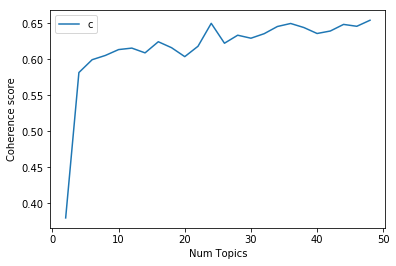

In [158]:
model_list, coherence_values = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=2, limit=50, step=2
)

limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [159]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 2  is having Coherence Value of 0.3799
Num Topics = 4  is having Coherence Value of 0.5816
Num Topics = 6  is having Coherence Value of 0.5994
Num Topics = 8  is having Coherence Value of 0.6054
Num Topics = 10  is having Coherence Value of 0.6135
Num Topics = 12  is having Coherence Value of 0.6156
Num Topics = 14  is having Coherence Value of 0.6089
Num Topics = 16  is having Coherence Value of 0.6244
Num Topics = 18  is having Coherence Value of 0.6161
Num Topics = 20  is having Coherence Value of 0.6037
Num Topics = 22  is having Coherence Value of 0.6181
Num Topics = 24  is having Coherence Value of 0.6499
Num Topics = 26  is having Coherence Value of 0.6223
Num Topics = 28  is having Coherence Value of 0.6334
Num Topics = 30  is having Coherence Value of 0.6293
Num Topics = 32  is having Coherence Value of 0.6356
Num Topics = 34  is having Coherence Value of 0.6455
Num Topics = 36  is having Coherence Value of 0.6497
Num Topics = 38  is having Coherence Value of 0.64

The results are not surprising anymore The curb starts to flatten around 8 and slowly goes up. let's check some of them anyway (it also help to see if we cleaned well our text this time)

In [162]:
optimal_model = model_list[11]

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

vis

vis = pyLDAvis.prepared_data_to_html(vis)

with open("11LDA_output24s-029.html", "w") as file:
    file.write(vis)

#model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


There are no weird words in the topics, even though we checked 48. Our cleaning must be good enough this time. We are saving 8 topic as well, and continue with 8. It is advised to keep the number of topic before the flattening of the curve.

In [53]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, iterations=2000, workers = 6, id2word=id2word)

In [216]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

vis

vis = pyLDAvis.prepared_data_to_html(vis)

with open("12LDA_output8s-029.html", "w") as file:
    file.write(vis)

/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/bilatli/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


display the topics

In [217]:
model_topics = ldamallet.show_topics(formatted=False) # as a list
pprint(ldamallet.print_topics(num_words=30))

[(0,
  '0.008*"护士" + 0.008*"防护服" + 0.008*"志愿者" + 0.007*"方舱" + 0.007*"发热" + '
  '0.006*"病房" + 0.006*"床位" + 0.005*"捐赠" + 0.005*"门诊" + 0.005*"收治" + '
  '0.004*"医疗队" + 0.004*"酒店" + 0.004*"支援" + 0.004*"家属" + 0.004*"同事" + '
  '0.004*"疑似" + 0.003*"病区" + 0.003*"医护" + 0.003*"定点医院" + 0.003*"求助" + '
  '0.003*"科室" + 0.003*"住院" + 0.003*"微" + 0.003*"火神" + 0.003*"信号" + '
  '0.003*"中心医院" + 0.002*"病情" + 0.002*"救治" + 0.002*"红十字会" + 0.002*"医务人员"'),
 (1,
  '0.009*"复工" + 0.008*"生产" + 0.007*"员工" + 0.007*"行业" + 0.005*"需求" + 0.004*"产品" '
  '+ 0.003*"政策" + 0.003*"工厂" + 0.003*"销售" + 0.003*"物流" + 0.003*"价格" + '
  '0.003*"订单" + 0.003*"业务" + 0.003*"办公" + 0.003*"成本" + 0.003*"消费" + 0.002*"收入" '
  '+ 0.002*"机构" + 0.002*"面临" + 0.002*"客户" + 0.002*"资金" + 0.002*"亿元" + '
  '0.002*"线上" + 0.002*"国内" + 0.002*"受" + 0.002*"恢复" + 0.002*"增长" + 0.002*"用户" '
  '+ 0.002*"项目" + 0.002*"线下"'),
 (2,
  '0.005*"孩子" + 0.004*"妈妈" + 0.004*"出门" + 0.003*"母亲" + 0.003*"回来" + 0.003*"小区" '
  '+ 0.003*"回" + 0.003*"超市" + 0.003*"父亲" + 0.003*"父母" + 0

In [245]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=30)] for n in range(0, ldamallet.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 31)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T


topics_df.to_csv (r'8topics_df.csv',index = False, header = True) #saving dataframe
#topics_df

Saving the model with pickle

In [54]:
import pickle
pickle.dump(ldamallet, open("ldamallet.pkl", "wb"))

#import joblib          #also possible with joblib
#joblib.dump(ldamallet, 'ldamallet.jl')

In [55]:
ldatest = pickle.load(open("ldamallet.pkl", "rb")) #loading the model with pickle
t = ldatest[corpus] #testing that the loading works -> ok

convert mallet model to gensim model

In [39]:
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [40]:
ldagensim = convertldaMalletToldaGen(ldamallet)

Let's see if we can add dominant topic per document. After that we will be able to choose what documents to translate based on that, at least partially.

In [41]:
def format_topics_sentences(ldamodel=ldagensim, corpus=corpus, texts=df_texts.texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldagensim, corpus=corpus, texts=df_texts.texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3258,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...
1,1,7.0,0.8128,"孩子, 出门, 妈妈, 小区, 回来, 回, 母亲, 超市, 东西, 群里",武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...
2,2,7.0,0.6750,"孩子, 出门, 妈妈, 小区, 回来, 回, 母亲, 超市, 东西, 群里",我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...
3,3,7.0,0.4157,"孩子, 出门, 妈妈, 小区, 回来, 回, 母亲, 超市, 东西, 群里",疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...
4,4,7.0,0.3763,"孩子, 出门, 妈妈, 小区, 回来, 回, 母亲, 超市, 东西, 群里",孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...


we can add our id column for easy check and selection

In [43]:
contents = pd.Series(df_texts.id)
newdf = pd.concat([df_dominant_topic, contents], axis=1)
newdf.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
0,0,1.0,0.3258,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,1
1,1,7.0,0.8128,"孩子, 出门, 妈妈, 小区, 回来, 回, 母亲, 超市, 东西, 群里",武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,2
2,2,7.0,0.6750,"孩子, 出门, 妈妈, 小区, 回来, 回, 母亲, 超市, 东西, 群里",我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,3
3,3,7.0,0.4157,"孩子, 出门, 妈妈, 小区, 回来, 回, 母亲, 超市, 东西, 群里",疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,4
4,4,7.0,0.3763,"孩子, 出门, 妈妈, 小区, 回来, 回, 母亲, 超市, 东西, 群里",孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,5


and see the dominant topic distribution amongs the articles

In [46]:
dominant_topic_df = pd.DataFrame()

xx = newdf.groupby(by='Dominant_Topic').size()
dominant_topic_df['Doc_Count'] = xx
dominant_topic_df['Total_Docs_Perc'] = xx
dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))


dominant_topic_df

,Doc_Count,Total_Docs_Perc
Dominant_Topic,,
0.0,611,13.86
1.0,492,11.16
2.0,579,13.14
3.0,438,9.94
4.0,466,10.57
5.0,314,7.12
6.0,505,11.46
7.0,1003,22.75


In [56]:
dominant_topic_df.Doc_Count.sum()

4408

Let's find out which are the most representative documents for each subjects

In [222]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
   sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text"
]
sent_topics_sorteddf_mallet.head()

,Topic_Number,Contribution_Perc,Keywords,Text
0,0.0,0.7472,"护士, 防护服, 志愿者, 方舱, 发热, 病房, 床位, 捐赠, 门诊, 收治",武汉收治确诊病人最多的定点医院从一片混沌到有了章法\n武汉收治确诊病人最多的定点医院从一片混...
1,1.0,0.8885,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 物流",病毒对石油煤炭有色冲击巨大钢铁却比往年更红火\n病毒对石油煤炭有色冲击巨大钢铁却比往年更红火...
2,2.0,0.8791,"孩子, 妈妈, 出门, 母亲, 回来, 小区, 回, 超市, 父亲, 父母",我家接的桌酒席终于取消了丨人间\n我家接的桌酒席终于取消了丨人间我家接的桌酒席终于取消了丨人...
3,3.0,0.8342,"美国, 意大利, 韩国, 日本, 英国, 伊朗, 国内, 欧洲, 航班, 德国",意大利累计确诊例韩国病亡人新天地教主被起诉\n意大利累计确诊例韩国病亡人新天地教主被起诉意大...
4,4.0,0.9228,"临床, 传染病, 疾病, 出院, 疫苗, 核酸, 药物, 诊断, 疾控中心, 感染者",愼愼挼昼搼昼挼昼戼戼搼昼挼戼昼挼搼搼搼挼戼戼愼愼愼戼攼挼攼戼搼挼昼戼愼挼戼挼搼挼挼挼搼挼昼戼...


In [223]:
sent_topics_sorteddf_mallet

,Topic_Number,Contribution_Perc,Keywords,Text
0,0.0,0.7472,"护士, 防护服, 志愿者, 方舱, 发热, 病房, 床位, 捐赠, 门诊, 收治",武汉收治确诊病人最多的定点医院从一片混沌到有了章法\n武汉收治确诊病人最多的定点医院从一片混...
1,1.0,0.8885,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 物流",病毒对石油煤炭有色冲击巨大钢铁却比往年更红火\n病毒对石油煤炭有色冲击巨大钢铁却比往年更红火...
2,2.0,0.8791,"孩子, 妈妈, 出门, 母亲, 回来, 小区, 回, 超市, 父亲, 父母",我家接的桌酒席终于取消了丨人间\n我家接的桌酒席终于取消了丨人间我家接的桌酒席终于取消了丨人...
3,3.0,0.8342,"美国, 意大利, 韩国, 日本, 英国, 伊朗, 国内, 欧洲, 航班, 德国",意大利累计确诊例韩国病亡人新天地教主被起诉\n意大利累计确诊例韩国病亡人新天地教主被起诉意大...
4,4.0,0.9228,"临床, 传染病, 疾病, 出院, 疫苗, 核酸, 药物, 诊断, 疾控中心, 感染者",愼愼挼昼搼昼挼昼戼戼搼昼挼戼昼挼搼搼搼挼戼戼愼愼愼戼攼挼攼戼搼挼昼戼愼挼戼挼搼挼挼挼搼挼昼戼...
5,5.0,0.8711,"评论, 登录, 代表, 观点, 金融, 博客, 仅, 政经, 投资, 微博",疫情总动员各地怎么做保交通重问责迟开学政经频道财新网\n疫情总动员各地怎么做保交通重问责迟开...
6,6.0,0.9137,"湖北省, 居民, 小区, 累计, 排查, 疑似病例, 通报, 单位, 部门, 指挥部",黄某刑满释放感染肺炎离汉进京始末湖北北京查处人\n黄某刑满释放感染肺炎离汉进京始末湖北北京查...
7,7.0,0.8275,"回复, 日记, 老师, 学生, 心理, 游戏, 写, 学习, 学校, 微博",网络直播上课第一周老师和学生在抓狂中适应游研社\n网络直播上课第一周老师和学生在抓狂中适应游...


In [224]:
df2 =newdf[newdf.Dominant_Topic==4] #selecting the problematic topic

In [172]:
df2

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
0,0,4.0,0.3453,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",个临时发往武汉的口罩\n个临时发往武汉的口罩个临时发往武汉的口罩个临时发往武汉的口罩吴呈杰报...,1
35,35,4.0,0.3457,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",旅行社老板荣荣我在临沂过年关原创\n旅行社老板荣荣我在临沂过年关原创旅行社老板荣荣我在临沂过...,36
41,41,4.0,0.4523,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",直击肺炎有人囤货涨价用现金交易线上断货线下断供\n直击肺炎有人囤货涨价用现金交易线上断货线下...,42
43,43,4.0,0.5247,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",天价口罩背后原料价一天一涨不惜亏本生产\n天价口罩背后原料价一天一涨不惜亏本生产天价口罩背后...,44
53,53,4.0,0.4488,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",湖北一亿只亟需饲料的蛋鸡\n湖北一亿只亟需饲料的蛋鸡湖北一亿只亟需饲料的蛋鸡湖北一亿只亟需饲...,54
62,62,4.0,0.4374,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",京东武汉战事金银潭医院米处为机枪手递上子弹深网\n京东武汉战事金银潭医院米处为机枪手递上子弹...,63
65,65,4.0,0.4968,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",一位教育培训创业者的抗疫计划我们准备这样扛过三个月深网\n一位教育培训创业者的抗疫计划我们准...,66
87,87,4.0,0.5746,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",口罩产能全球过半为何还是一罩难求\n口罩产能全球过半为何还是一罩难求口罩产能全球过半为何还是...,88
91,91,4.0,0.4658,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",猪也饿二师兄挺住\n猪也饿二师兄挺住猪也饿二师兄挺住猪也饿二师兄挺住李晓洁杨璐三联生活周刊三...,92
118,118,4.0,0.3393,"复工, 生产, 员工, 行业, 需求, 产品, 政策, 工厂, 销售, 价格",和疫情一线的医生聊的越多就越尊重他们\n和疫情一线的医生聊的越多就越尊重他们和疫情一线的医生...,119


In [225]:
df2.sort_values('Topic_Perc_Contrib', ascending = False) #reorder by percentage contribution
df2.to_csv (r'df2check.csv', index = False, header=True) #with index

In [182]:
df3 =newdf[newdf.Dominant_Topic==7] #selecting other topic
df3

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
1,1,7.0,0.7864,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",武汉隔离疫区信息孤岛与一辆鄂车的漂流\n武汉隔离疫区信息孤岛与一辆鄂车的漂流武汉隔离疫区信息...,2
2,2,7.0,0.6596,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",我家离华南海鲜市场很近返乡封城过年一位武汉大学生的过去一周\n我家离华南海鲜市场很近返乡封城...,3
3,3,7.0,0.4137,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",疫情危机中不被看见的人们武汉周边城市百姓的自救行动\n疫情危机中不被看见的人们武汉周边城市百...,4
4,4,7.0,0.3740,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",孝感前线医生武汉更难我们下面不好意思提要求\n孝感前线医生武汉更难我们下面不好意思提要求孝感...,5
6,6,7.0,0.4666,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",外卖骑手出租车司机快递员志愿者封城九日他们维护着武汉的血脉\n外卖骑手出租车司机快递员志愿者...,7
8,8,7.0,0.5919,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",鸡在瘟疫蔓延时\n鸡在瘟疫蔓延时鸡在瘟疫蔓延时鸡在瘟疫蔓延时蔚琳颖迪呈杰敏洁报道报道记录人物...,9
9,9,7.0,0.7969,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",武汉封城后的宠物营救计划人类犯错的后果不该由它们承担\n武汉封城后的宠物营救计划人类犯错的后...,10
15,15,7.0,0.7124,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",地球青年丨武汉的除夕夜我一个人在家自行观察\n地球青年丨武汉的除夕夜我一个人在家自行观察地球...,16
16,16,7.0,0.6409,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",在人间丨父亲双肺感染严重然而一床难求\n在人间丨父亲双肺感染严重然而一床难求在人间丨父亲双肺...,17
17,17,7.0,0.7540,"孩子, 妈妈, 出门, 回来, 母亲, 小区, 回, 超市, 群里, 东西",在人间丨妈妈在武汉隔离病房去世\n在人间丨妈妈在武汉隔离病房去世在人间丨妈妈在武汉隔离病房去...,18


In [226]:
newdf[newdf.id==1441]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
1424,1424,2.0,0.3611,"孩子, 妈妈, 出门, 母亲, 回来, 小区, 回, 超市, 父亲, 父母",武汉方舱医院一个护士的诗\n武汉方舱医院一个护士的诗武汉方舱医院一个护士的诗武汉方舱医院一个...,1441


In [227]:
newdf[newdf.id==3655]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
3628,3628,2.0,0.5915,"孩子, 妈妈, 出门, 母亲, 回来, 小区, 回, 超市, 父亲, 父母",对解封的消息免疫郭晶的武汉封城日记\n对解封的消息免疫郭晶的武汉封城日记对解封的消息免疫郭晶...,3655


In [228]:
newdf[newdf.id==3315]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,id
3288,3288,6.0,0.5744,"湖北省, 居民, 小区, 累计, 排查, 疑似病例, 通报, 单位, 部门, 指挥部",武汉一社区用环卫车运送平价肉人被免职青山区纪委界面新闻青山区纪委官网消息年月日时许青山区委区...,3315
